In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
from mlpp.hawkesnoparam.estim import Estim
import mlpp.pp.hawkes as hk
import whma.simulation as simu
from mlpp.base.utils import TimeFunction
from whma.metrics import rel_err, rank_corr

In [2]:
# simulation of Hawkes processes
d = 10
mu = 0.005 * np.ones(d)
mus = simu.simulate_mu(d, mu=mu)
blocks = [5,5]
L = []
L.append(np.ones((blocks[0],blocks[0])))
L.append(np.ones((blocks[1],blocks[1])))
Alpha_truth = scipy.linalg.block_diag(*L) / 6
# add noise
#Alpha_truth += 0.01

## Major key: 
### Since hMax=40 encodes the support, we ensure \beta is not too small for estimation
We define $\beta_{\min}$ and $\beta_{\max}$ such that $$\mbox{hMax} \times \beta_\min = \mbox{ln}(1000)$$ $$\mbox{hDelta} \times \beta_\max = 10^{-2}$$

In [18]:
hMax = 40
hDelta = .001
from math import log
beta_min = log(1000) / hMax
beta_max = 1e-2 / hDelta
print("We have")
print("    beta_min = ",beta_min)
print("    beta_max = ",beta_max)

We have
    beta_min =  0.17269388197455343
    beta_max =  10.0


In [3]:
LL = []
LL.append(beta_max*np.ones((blocks[0],blocks[0])))
LL.append(beta_min*np.ones((blocks[1],blocks[1])))
Beta = scipy.linalg.block_diag(*LL)

In [4]:
_, s, _ = np.linalg.svd(Alpha_truth)
print(s.max())
assert s.max() < 1, "Alpha_truth cannot generate a stable Hawkes process"

0.833333333333


/Users/massil/anaconda/envs/py3k/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


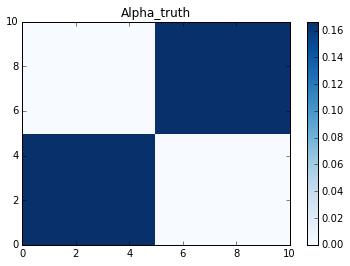

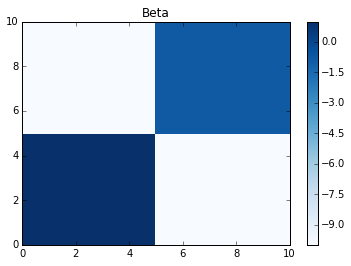

In [5]:
plt.pcolor(Alpha_truth,cmap=plt.cm.Blues)
plt.title("Alpha_truth")
plt.colorbar()
plt.show()
plt.close()
#plt.pcolor(Beta,cmap=plt.cm.bwr)
plt.pcolor(np.log10(1e-10+Beta),cmap=plt.cm.Blues)
plt.title("Beta")
plt.colorbar()
plt.show()
plt.close()

In [6]:
kernels = [[hk.HawkesKernelExp(a, b) for (a, b) in zip(a_list, b_list)] for (a_list, b_list) in zip(Alpha_truth, Beta)]
h = hk.Hawkes(kernels=kernels, mus=list(mus))
h.simulate(100000)
estim = Estim(h, n_threads=8, hDelta=hDelta, hMax=hMax)

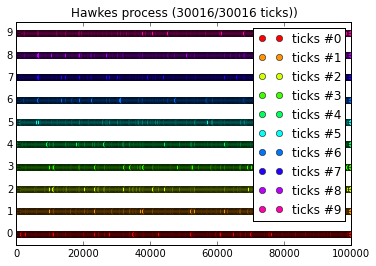

In [7]:
h.plot()

## Number of points

In [8]:
for i in range(h.dimension):
    print("i="+str(i)+"     "+str(len(h.get_full_process()[i])))

i=0     3061
i=1     3118
i=2     3081
i=3     3030
i=4     3101
i=5     2957
i=6     2874
i=7     2970
i=8     2838
i=9     2986


## Correlation matrix

/Users/massil/anaconda/envs/py3k/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


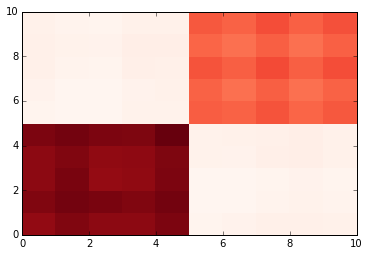

In [9]:
from whma.cumulants import get_C
Corr = get_C(estim)
plt.pcolor(Corr,cmap=plt.cm.Reds)
plt.show()
plt.close()

# Estimation procedure

In [10]:
from whma.solver import admm
import whma.prox as prox
X0 = np.eye(d)
#X0 = np.ones(d**2).reshape(d,d)
rho = 0.001
maxiter = 10000

## objective = squared Frobenius

||X1 - X_2|| =  7.14430290382e-08
||X2 - X_3|| =  1.19985791533e-15
||U1|| =  0.00036985112296
||U2|| =  0.000454975055534
||U3|| =  1.5979855382e-15
||U4|| =  0.00215152678931
||U5|| =  0.000574348946681


/Users/massil/anaconda/envs/py3k/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


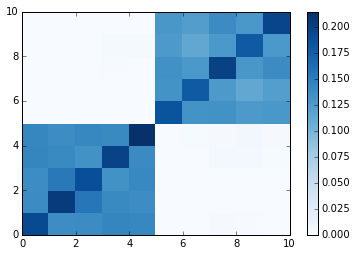

RelErr =  0.0932710416362
RankCorr =  0.374027894635


In [11]:
# main step
X_frob = admm(estim, prox.sq_frob, X0, X0, Alpha_truth, rho=rho, maxiter=maxiter)
plt.pcolor(X_frob,cmap=plt.cm.Blues)
plt.colorbar()
plt.show()
plt.close()
print("RelErr = ", rel_err(Alpha_truth, X_frob))
print("RankCorr = ", rank_corr(Alpha_truth, X_frob))

In [12]:
print("True norm = ", Alpha_truth[0,0])
print("mean norm HF = ",np.mean(X_frob[:5,:5]))
print("mean norm LF = ",np.mean(X_frob[5:,5:]))

True norm =  0.166666666667
mean norm HF =  0.153227266286
mean norm LF =  0.140326417795


## objective = \ell_1 norm

||X1 - X_2|| =  3.08589086899e-10
||X2 - X_3|| =  1.91336065711e-15
||U1|| =  0.00323274631085
||U2|| =  0.00022052136393
||U3|| =  8.34581059273e-16
||U4|| =  0.0186715699278
||U5|| =  0.00487555977684


/Users/massil/anaconda/envs/py3k/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


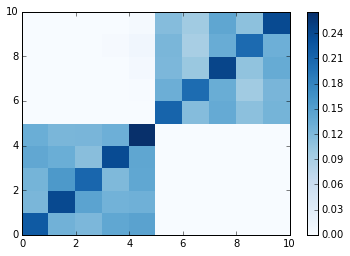

RelErr =  0.134148392463
RankCorr =  0.412704797392


In [13]:
# main step
X_l1 = admm(estim, prox.l1, X0, X0, Alpha_truth, rho=rho, maxiter=maxiter)
plt.pcolor(X_l1,cmap=plt.cm.Blues)
plt.colorbar()
plt.show()
plt.close()
print("RelErr = ", rel_err(Alpha_truth, X_l1))
print("RankCorr = ", rank_corr(Alpha_truth, X_l1))

In [14]:
print("True norm = ", Alpha_truth[0,0])
print("mean norm HF = ",np.mean(X_l1[:5,:5]))
print("mean norm LF = ",np.mean(X_l1[5:,5:]))

True norm =  0.166666666667
mean norm HF =  0.153306854761
mean norm LF =  0.140132170334


## objective = nuclear norm

||X1 - X_2|| =  6.13894930276e-09
||X2 - X_3|| =  1.73310079702e-15
||U1|| =  0.00108707484045
||U2|| =  0.00426578643466
||U3|| =  6.32989682838e-16
||U4|| =  0.00627128355419
||U5|| =  0.00474330084796


/Users/massil/anaconda/envs/py3k/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


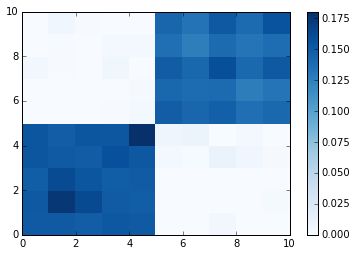

RelErr =  0.0600425532639
RankCorr =  0.374027894635


In [15]:
# main step
X_nuc = admm(estim, prox.nuclear, X0, X0, Alpha_truth, rho=rho, maxiter=maxiter)
plt.pcolor(X_nuc,cmap=plt.cm.Blues)
plt.colorbar()
plt.show()
plt.close()
print("RelErr = ", rel_err(Alpha_truth, X_nuc))
print("RankCorr = ", rank_corr(Alpha_truth, X_nuc))

In [16]:
print("True norm = ", Alpha_truth[0,0])
print("mean norm HF = ",np.mean(X_nuc[:5,:5]))
print("mean norm LF = ",np.mean(X_nuc[5:,5:]))

True norm =  0.166666666667
mean norm HF =  0.154357302602
mean norm LF =  0.141358033378
